In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

What is the Emission factor?  A lot of activities today results in the release of Green House Gases(GHG) in the atmosphere. There are various activities that contribute to the release of GHG like burning fuel, vehicles, Power Plants, etc. Therefore, in order to estimate GHG emissions per unit of available activity, we need to use a factor called emission factor (EF).[source] For example: how many kgs of GHG are emitted by 1 kWh of natural gas? Thus, an emission factor is a coefficient that converts any activity's data into GHG emissions. This factor attempts to relate the quantity of a pollutant released to the atmosphere with an activity associated with the release of that pollutant.
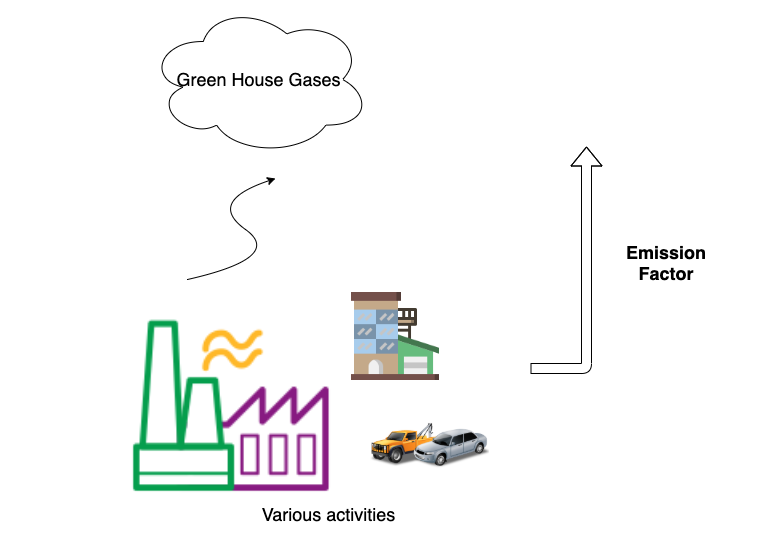

In [ ]:
#importing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Analysing datetime
import datetime as dt
from datetime import datetime
#plotting geographical data
import folium
import rasterio as rio
#file system mgmt
import os
#supress warnings
import warnings
warnings.filterwarnings('ignore')

Exploring the Global Power Plant Database for Puerto Rico
The given gppd_120_pr.csv consists of all the power plants which belongs to the Puerto Rico, an unincorporated territory of the United States located in the northeast Caribbean Sea.The latitude of Puerto Rico is 18.200178, and the longitude is -66.664513. The island has been chosen for the analysis since there are fewer confounding factors from nearby areas. Puerto Rico also offers a unique fuel mix and distinctive energy system layout that should make it easier to isolate pollution attributable to power generation in the remote sensing data.

In [ ]:
#Total number of power plants in puerto rico
global_power_plants = pd.read_csv('../input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')
global_power_plants.head().T

Before analysing further, let's understand what some of the attributes mean.

* capacity_mw - electrical generating capacity in megawatts
* commissioning_year - year of plant operation, weighted by unit-capacity when data is available
* estimated_generation_gwh - estimated annual electricity generation in gigawatt-hours
* generation_gwh_2013 - electricity generation in gigawatt-hours for the year 2013
* gppd_idnr - estimated annual electricity generation in gigawatt-hours for the year 2014
* name - name or title of the power plant
* primary_fuel - energy source used in primary electricity generation or export
* wepp_id - a reference to a unique plant identifier in the widely-used PLATTS-WEPP datase
* year_of_capacity_data -year the capacity information was reported
* source - entity reporting the data
* owner - majority shareholder of the power plant

In [ ]:
#number of different power plants
global_power_plants.shape

In [ ]:
#lets check the different kinds of power plants based on primary fuel used
sns.barplot(x=global_power_plants['primary_fuel'].value_counts().index, 
            y=global_power_plants['primary_fuel'].value_counts())
plt.ylabel('count')

How old are the plants

Power plants built decades ago tend to pollute more since they donot meet the newer anti-pollution requirements.

In [ ]:
global_power_plants['commissioning_year'].value_counts()

Well, a lot of powerplants donot have their date of Commission. The plants are as old as 1942 and the latest one belongs to the year 2012

In [ ]:
#The different sources of data
fig = plt.gcf()
fig.set_size_inches(10,6)
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow']
global_power_plants['source'].value_counts(ascending=True).plot(kind='barh',color=colors,linewidth=2,edgecolor='black')

The majority of the data came from CEPR followed by PREPA(Puerto Rico Electric Power Authority)


In [ ]:
#Who  is the ownner the power plants

fig = plt.gcf()
fig.set_size_inches(10, 6)
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow'] 
global_power_plants['owner'].value_counts(ascending=True).plot(kind='barh',color=colors)


PREPA is a government agency that owns the electricity transmission and distribution systems for the main island, Vieques, and Culebra, as well as 80% of the electricity generating capacit

Total Installed Capacity
The Total Installed capacity of a power plant refers to the maximum output of electricity that it can produce under ideal conditions but this won’t necessarily be the actual amount of electricity produced.It is usually expressed in megawatts (MW)

In [ ]:
# Total capacity of all the plants
total_capacity_mw = global_power_plants['capacity_mw'].sum()
print('Total Installed Capacity: '+'{:.2f}'.format(total_capacity_mw) + ' MW')

In [ ]:
capacity = (global_power_plants.groupby(['primary_fuel'])['capacity_mw'].sum()).to_frame()
capacity = capacity.sort_values('capacity_mw',ascending=False)
capacity['percentage_of_total'] = (capacity['capacity_mw']/total_capacity_mw)*100
capacity

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
colors = ['dodgerblue', 'plum', '#F0A30A','#8c564b','orange','green','yellow'] 
capacity['percentage_of_total'].plot(kind='bar',color=colors)

Oil run plants consitutes about 68% of Puerto Rico’s total installed capacity and natural gas accounted for 18%. Coal continues to fuel 7% of generation, while renewables supplied around 5.5%.

Estimated generation
Electricity generation, on the other hand, refers to the amount of electricity that is produced over a specific period of time. This is usually measured in kilowatt-hours, megawatt-hours o gigawatt-hours.

In [ ]:
# Total generation of all the plants
total_gen_mw = global_power_plants['estimated_generation_gwh'].sum()
print('Total Generatation: '+'{:.2f}'.format(total_gen_mw) + ' GW')

In [ ]:
generation = (global_power_plants.groupby(['primary_fuel'])['estimated_generation_gwh'].sum()).to_frame()
generation = generation.sort_values('estimated_generation_gwh',ascending=False)
generation['percentage_of_total'] = (generation['estimated_generation_gwh']/total_gen_mw)*100
generation

A geographical view of the various Power Plants
We can use the power plant dataset to visualise the existing locations of the various power plant. We will extract the latitudes and longitudes from the geo column

In [ ]:
# Code source: https://www.kaggle.com/paultimothymooney/overview-of-the-eie-analytics-challenge
from folium import plugins      
def plot_points_on_map(dataframe,begin_index,end_index,latitude_column,latitude_value,longitude_column,longitude_value,zoom):
    df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    plot = folium.Map(location=location,zoom_start=zoom,tiles = 'Stamen Terrain')
    
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.primary_fuel[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],
                       df[longitude_column].iloc[i]],
                       popup=popup,icon=folium.Icon(color='white',icon_color='red',icon ='bolt',prefix='fa',)).add_to(plot)
    return(plot)

def overlay_image_on_puerto_rico(file_name,band_layer,lat,lon,zoom):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=zoom)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m

def split_column_into_new_columns(dataframe,column_to_split,new_column_one,begin_column_one,end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe
    

In [ ]:
global_power_plants = split_column_into_new_columns(global_power_plants,'.geo','latitude',50,66)
global_power_plants = split_column_into_new_columns(global_power_plants,'.geo','longitude',31,48)
global_power_plants['latitude'] = global_power_plants['latitude'].astype(float)
a = np.array(global_power_plants['latitude'].values.tolist()) 
global_power_plants['latitude'] = np.where(a < 10, a+10, a).tolist() 

lat=18.200178; lon=-66.664513 # Puerto Rico's co-ordinates
plot_points_on_map(global_power_plants,0,425,'latitude',lat,'longitude',lon,9)

In [ ]:
image = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'

# Opening the file
raster = rio.open(image)

# All Metadata for the whole raster dataset
raster.meta

* Driver : Data Format
* dtype : data type
* width and Height : The dimensions of the image are : 475 X 148
* count : There are 12 bands in the image
* crs: Coordinate Reference Systems which refers to the way in which spatial data that represent the earth’s surface.A particular CRS can be referenced by its EPSG code (i.e.,epsg:4121). The EPSG is a structured dataset of CRS and Coordinate Transformations(link]
* transform : Affine transform (how raster is scaled, rotated, skewed, and/or translated)

In [ ]:
from rasterio.plot import show
show(raster)

In [ ]:
# Plotting the red channel.
show((raster, 4), cmap='Reds')

Bands
The satellites cover the full earth on 13 bands with a revisiting every 5 days.

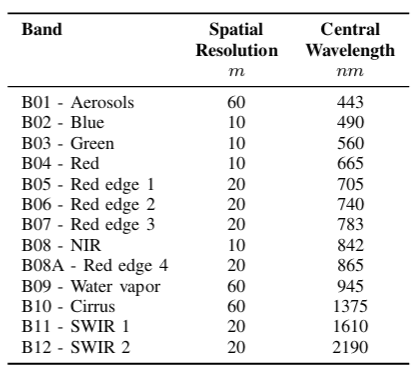

In [ ]:
# Calculating the dimensions of the image on earth in metres
sat_data = raster

width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

In [ ]:
# Upper left pixel
row_min = 0
col_min = 0
# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1
# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)
print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

In [ ]:
print(sat_data.count)

# sequence of band indexes
print(sat_data.indexes)

In [ ]:
# Load the 12 bands into 2d arrays
b01, b02, b03, b04,b05,b06,b07,b08, b09,b10, b11, b12 = sat_data.read()

In [ ]:
# Displaying the second band.

fig = plt.imshow(b02)
plt.show()

In [ ]:
fig = plt.imshow(b03)
fig.set_cmap('gist_earth')
plt.show()

In [ ]:
fig = plt.imshow(b04)
fig.set_cmap('inferno')
plt.colorbar()
plt.show()

In [ ]:
# Displaying the infrared band.

fig = plt.imshow(b08)
fig.set_cmap('winter')
plt.colorbar()
plt.show()